$\LARGE{NRE\ final\ assignment}$

This assignment is divided into 2 parts. In the first section, functions are built for analysis, e.g. simple kriging and sequential gaussian simulation functions. Later in the second section, standard statistical analysis, simple kriging and sequential Gaussian simulation are applied to 6 pictures for comparison.

In [1]:
NAME = 'Yi Zhang'
MATNUM = '384770'

In [2]:
import numpy as np
%matplotlib inline
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.table import Table,Column
import scipy.spatial.distance as dist
from collections import OrderedDict
from skimage import transform,data
from scipy import stats
import scipy.optimize
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# Build functions

In this chapter, functions are created for later use.

## Read image

In [3]:
def R(im,seed,nrandompoints):
    '''
    Read function
    ***Input***
      im: matrix obtained from ndimage.imread('filename.jpg',mode='I')
      seed: random seed for random sample points
      nrandompoints: number of random sample points
    ***Return***
      A matrix, Z of the random points data. Z[:,0]: x location. Z[:,1]:\
      y location. Z[:,2]: grayscale value of the point.
    im=ndimage.imread('filename',mode='I')
    '''
    np.random.seed(seed)
    y_max,x_max=im.shape
    x_random=np.random.uniform(0,x_max,nrandompoints)
    y_random=np.random.uniform(0,y_max,nrandompoints)
    training_vals=im[y_random.astype('int'),x_random.astype('int')]
    fig=plt.figure(figsize=[8,8])
    ax=fig.add_subplot(111)
    ax1=ax.imshow(im)
    clb=fig.colorbar(ax1)
    clb.set_label('grayscale', labelpad=-27, y=-0.1, rotation=0)
    ax.plot(x_random,y_random,'r.',label='sampling points')
    ax.legend(loc=[1.3,0])
    ax.set_title('original image')
    return np.vstack([np.vstack([x_random,y_random]),training_vals]).T

## Standard statistical analysis

In [4]:
def S(R_return,im):
    '''
    Standard statistical function
    ***Input***
      R_return: return from function R
      im: matrix obtained from ndimage.imread('filename.jpg',mode='I')
    ***Output***
      Mean and standard deviation of R_return[:,2]
      Normal distribution test
      Histogram of R_return[:,2]
      Image generation based on mean and standard deviation
    '''
    fig1=plt.figure()
    ax2=fig1.add_subplot(111)
    ax2.hist(R_return[:,2],50,density=0,edgecolor='black')
    ax2.set_xlabel('grayscale')
    ax2.set_ylabel('counts')
    ax2.set_title('Histogram of grayscale samples')
    m=np.mean(R_return[:,2]) # Mean
    sd=np.std(R_return[:,2]) # Standard deviation
    print('the Mean of the grayscale samples is %f\nThe standard deviation of the grayscale samples is %f'%(m,sd))
    print(stats.normaltest(R_return[:,2]))
    
    # Generate a random image based on mean and standard deviation
    np.random.seed(12345)
    random_im=np.random.normal(loc=m,scale=sd,size=im.shape) # random number is created based on normal distribution
    fig2=plt.figure(figsize=[8,8])
    ax3=fig2.add_subplot(111)
    ax4=ax3.imshow(random_im)
    clb=fig2.colorbar(ax4)
    clb.set_label('grayscale', labelpad=-27, y=-0.1, rotation=0)
    ax3.set_title('random image based on mean and\nstandard deviation of the random samples')

## Compute experimental variogram

In [5]:
def variogram(R_return,lag_start,lag_stop,lag_step,tol):
    '''
    Variogram calculation function
    ***Input***
      R_return: return from function R
      lag_start/stop/step/tol: start/stop/step/tolerance in experimental variogram analysis
    ***Output***
      A variogram plot
    ***Return***
      lags and corresponding semivariograms
    '''
    
    lags = np.arange(lag_start, lag_stop, lag_step)
    all_semivars=[]
    
    # Extract data in selected range
    def e(R_teturn,l,lag,tol):
        a=R_return[(np.sqrt((R_return[:,0]-l[0])**2+(R_return[:,1]-l[1])**2)<lag+tol)\
                &(np.sqrt((R_return[:,0]-l[0])**2+(R_return[:,1]-l[1])**2)>lag-tol)]
        return a
    
    # Calculate the semi-variogram for a given lag and tol
    def extend_extr(R_return,lag,tol):
        semivar_values=np.array([])
        for i in range(len(R_return[:,0])):
            # Location of the selected point for each loop
            l=R_return[i,0:2]
            # Value of point
            v=R_return[i,2]
            # Get data in range with the same function
            data_filtered=e(R_return,l,lag,tol)[:,2]
            
            # Calculate semivar_value
            semivar_values=np.append(semivar_values,np.array((data_filtered-v)**2))
        return semivar_values
    
    lags=np.arange(lag_start, lag_stop, lag_step)
    
    # Calculate semivariance for all lags:
    for lag in lags:
        semivar_vals=extend_extr(R_return,lag,tol)
        all_semivars.append(0.5*np.mean(semivar_vals))
    fig3=plt.figure()

    return lags,all_semivars

## Define variogram model

exponential variogram:
$$ \gamma(|\boldsymbol{h}|)=c_0(1-exp\frac{-3|\boldsymbol{h}|}{r})$$

where,<br>
&emsp; $\gamma(|\boldsymbol{h}|)$ is variogram function;<br>
&emsp; $c_0$ is sill;<br>
&emsp; r is range.

In [6]:
def exp_var(lag,r,c0):
    '''
    variogram model function
    ***Input***
      lag: lag
      r: range of experimental variogram
      c0: sill of experimental variogram
    ***Return***
      variogram
    '''
    return c0*(1-np.exp((-3 * lag)/r))

## Fit experimental variogram

In [7]:
def fit_variogram(variogram_return,variogram_model,r,c0):
    '''
    Experimental variogram fitting function
    ***Input***
       variogram_return: return from variogram calculation function
       variogram_model: variogram model function
       r: initial guess of range
       c0: initial guess of sill
    ***Output***
      The fitting parameters of r and c0
      Standard deviation of fitting errors
      Fitting graph
    ***Return***
      The fitting parameters of r and c0
    '''
    [popt,pcov]=curve_fit(variogram_model,variogram_return[0],variogram_return[1],p0=[r,c0]) #p0 is \
    #the initial guess of the parameters
    sim_lags=np.linspace(0,np.max(variogram_return[0]),500)
    
    fig4=plt.figure()
    ax5=fig4.add_subplot(111)
    ax5.scatter(variogram_return[0],variogram_return[1],label='experimental variogram')
    ax5.set_title('variogram')
    ax5.set_xlabel('|h|')
    ax5.set_ylabel('$\hat{\gamma}(h)$')
    ax5.legend()
    ax5.plot(sim_lags,exp_var(sim_lags,popt[0],popt[1]),'--',color='grey'\
             ,linewidth=2,label='optimized simulated semivariogram')
    ax5.legend()
    print('The two parameters: %a' %(popt))
    print('Standard deviation of errors of fitting: %a' %(np.sqrt(np.diag(pcov)))) # variance of fitting
    return popt

## Covariance function

$$ C(|\boldsymbol{h}|)=\gamma(r)-\gamma(|\boldsymbol{h}|)$$

where C is the covariance function.

In [8]:
# Transform variogram to covariance
def C(h,fit_variogram_return,variogram_model=exp_var):
    '''
    Covariance function
    ***Input***
      h: lag
      fit_variogram_return: return from function fit_variogram
      variogram_model: variogram model
    ***Return***
      Covariance
    '''
    return (variogram_model(fit_variogram_return[0],fit_variogram_return[0],fit_variogram_return[1])\
            -variogram_model(h,fit_variogram_return[0],fit_variogram_return[1]))

## Simple kriging (SK)

In [9]:
# Simple Kriging function
def sk(est_loc,data,cf,fit_variogram_return):
    '''
    Simple kriging function
    This function returns kriging estimates and variance simultaneously
    **Input**:
        est_loc: estimated location [x,y]
        data: data matrix; x=data[:,0]; y=data[:,1]; z=data[:,2]
        cf: covariance function
        fit_variogram_return: return from experimental variogram fitting function
    **Return**:
        z: kriging estimate
        var: variance
    '''
    # This function can process any amounts (>1) of x_pos and por dataset, not restricted to 3

    # obtain matrix C0
    D=dist.squareform(dist.pdist(data[:,0:2]))
    C0=cf(D,fit_variogram_return)
    
    # obtain matrix c0
    d=dist.cdist([est_loc], data[:,0:2])[0]
    c0=cf(d,fit_variogram_return)
    
    # solve w from C0*w=c0
    w=np.linalg.solve(C0,c0)
    
    # calculate estimation z
    m=np.mean(data[:,2])
    z=m+np.dot(w,data[:,2]-m)
    var2=cf(0,fit_variogram_return)-np.dot(w,c0)
    return z,var2

In [10]:
def sk_grid(im,R_return,sk,cf,x_resolution,fit_variogram_return):
    '''
    Function to krige all grids
    ***Input***
       im: matrix obtained from ndimage.imread('filename.jpg',mode='I')
       R_return: return from function R
       sk: simple kriging function
       cf: covariance function
       x_resolution: grid numbers taken on x-axis; y_resolution is calculated based on x_resolution
       fit_variogram_return: return from experimental variogram fitting function
    ***Return***
      z1: kriging grids
      var1: kriging variance grids
    '''
    
    y_max,x_max=im.shape
    y_resolution=int(y_max/x_max*x_resolution)
    x_e_loc=np.arange(x_resolution)/x_resolution*x_max
    y_e_loc=np.arange(y_resolution)/y_resolution*y_max
    [xx,yy]=np.meshgrid(x_e_loc,y_e_loc)
    
    
    z=np.array([])
    var3=np.array([])
    for i in range(np.shape(xx)[0]):
        for j in range(np.shape(xx)[1]):
            z=np.append(z,sk([xx[i,j],yy[i,j]],R_return,cf,fit_variogram_return)[0])
            var3=np.append(var3,sk([xx[i,j],yy[i,j]],R_return,cf,fit_variogram_return)[1])
    z1=z.reshape(y_resolution,x_resolution)
    z1=transform.resize(z1,(y_max,x_max)) # recover the original size
    var1=var3.reshape(y_resolution,x_resolution)
    var1=transform.resize(var1,(y_max,x_max)) # recover the original size
    return z1,var1

## Data transform

Reference:<br>
Pyrcz, M.J., Deutsch, C.V. (2018). Transforming Data to a Gaussian Distribution. In J. L. Deutsch (Ed.), Geostatistics Lessons. Retrieved from http://www.geostatisticslessons.com/lessons/normalscore

### Normalization (before SGS)

$$ y=F_y ^{-1}(F_z(z)) $$

y: normal score value with standard normal distribution<br>
$F_y$: cumulative function for standard normal distribution<br>
$F_z$: cumulative function for z<br>
z: variable<br>
$^{-1}$: inversed function

In this step, z is transformed to y

In [11]:
def Fz(z,data):
    '''
    Cumulative function:
      this function firstly get scatter point [x,y] of cumulative function. If a new value x is given, 
      it tires to interpolate to give the corresponding cumulative value y
    ***Input***
      z: given vlue
      data: database
    ***Return***
      corresponding cumulative value for z
    '''
    
    # Cumulative function scatter
    # 999 scatters of cumulative function to ensure the accuracy
    values,base=np.histogram(data,999)
    cumulative = np.cumsum(values)
    cum=cumulative/len(data)
    
    base1=base[0:-1]
    
    # Cumulative function from discrete to continuos through linear interpolation\
    # between 2 neighbors
    for i in range(len(base1)-1):
        if (z>=base1[i]) & (z<=base1[i+1]):
            return 0.5*(cum[i]+cum[i+1])
        # If the given data x is too small, then return 0.01 rather than 0. Since\
        # normal distribution cumulative function cannot reach 0. Same thing is \
        # done for exceeding given data x
        elif z<np.min(base1):
            return 0.01
        elif z>np.max(base1):
            return 0.99

In [12]:
def normalization(Fz,data1):
    '''
    Normalization function:
      transform non-normal distribution to standard normal distribution
    ***Input***
      Fz: cumulative function
      data1: data array that is to be normalized
    ***Return***
      z_s: normalized array of data1
    '''
    cum_list=np.array([])
    for i in data1:
        cum_list=np.append(cum_list,Fz(i,data1))
    # norm.ppf: inversed cumulative function of standard normal distribution
    z_s=norm.ppf(cum_list)
    return z_s

### Back transformation (method included in SGS function)

$$ z=F_z^{-1}(F_y(y))$$

In this step, y is transformed back to z.

In [13]:
def Fz_inv(y,data):
    '''
    Inversed cumulative function
    ***Input***
      z: given cumulative value
      data: database
    ***Return***
      corresponding value to z
    '''
    # Cumulative function scatter
    # 999 scatters of cumulative function to ensure the accuracy
    values,base=np.histogram(data,999)
    cumulative=np.cumsum(values)
    cum=cumulative/len(data)
    
    #plt.scatter(base[0:-1],cum,c='blue')
    base1=base[0:-1]
    
    # Cumulative function from discrete to continuos through linear interpolation\
    # between 2 neighbors
    
    for i in range(len(cum)-1):
        if (y>=cum[i]) & (y<=cum[i+1]):
            return 0.5*(base1[i]+base1[i+1])
        # If cumulative value is smaller than the minimum cum, then return mean-std just in case
        elif y<np.min(cum):
            return (np.mean(base1)-np.std(base1))
        elif y>np.max(cum):
            return (np.mean(base1)+np.std(base1))

In [14]:
def denormalization(Fz_inv,data1,data2):
    '''
    ***Input***
      Fz_inv: inversed cumulative function
      data1: data list after SGS that is to be denormalized
      data2: original data
    ***Return***
      z_d: denormalized array of data1
    '''
    
    # norm.cdf: cumulative function of standard normal distribution
    value_array=norm.cdf(data1)
    
    z_d=np.array([])
    for i in value_array:
        z_d=np.append(z_d,Fz_inv(value_array,data2))
    return value_array

## Sequential Gaussian Simulation (SGS)

In [15]:
def sgs(im,R_return_sgs,seed,sk,C,Fz_inv,R_return,x_resolution,fit_variogram_return):
    '''
    SGS function:
      normalization of data is required before SGS and back transform is included in this function
    ***Input***
      im: matrix obtained from ndimage.imread('filename.jpg',mode='I')
      R_return_sgs: return from function R, should be normalized (normal transformation) through normalization function
      sk: SK function
      x_resolution: resolution on x-axis; y_resolution is calculated based on x_resolution
      C: covariance function
      Fz_inv: inversed cumulative function
    ***Return***
    data3:SGS grids
    '''
    # Grid creation
    y_max,x_max=im.shape
    # Calculate y_resolution based on x_resolution
    y_resolution=int(y_max/x_max*x_resolution)
    x_e_loc=np.arange(x_resolution)/x_resolution*x_max
    y_e_loc=np.arange(y_resolution)/y_resolution*y_max
    # x, y, location in matrix
    [xx,yy]=np.meshgrid(x_e_loc,y_e_loc) 
    # x location in a list
    x1=xx.reshape(np.shape(xx)[0]*np.shape(xx)[1],) 
    # y location in a list
    y1=yy.reshape(np.shape(yy)[0]*np.shape(yy)[1],)
    # Grid obtained: x1 on the 3rd column is just to form the shaple, which will be replaced by the SGS result later
    data1=np.vstack([np.vstack([x1,y1]),x1]).T 
    
    # Create random order to visit
    random.seed(seed)
    # Random order of rows of data1
    o=random.sample(range(0,np.shape(x1)[0]),np.shape(x1)[0])
    
    np.random.seed(seed)
    for i in o:
        # Go to a random location
        x0=data1[i,0:2] 
        d=dist.cdist([x0],R_return_sgs[:,0:2])[0]
        # number of closest points
        n=20 
        ids=np.argsort(d)
        # Search for proximate data
        data3=R_return_sgs[ids[:n],:]
        # Kriging estimate and SK variance
        ke=sk(x0,data3,C,fit_variogram_return)
        # Draw a normal distribution with mean of Kriging estimate and variance of SK variance. And put the new SGS data into\
        # data1 (grid created before)
        data1[i,2]=np.random.normal(ke[0],np.sqrt(ke[1]))
        # Add estimated data back to the dataset
        R_return_sgs=np.vstack([R_return_sgs,data1[i,:]])
        
    # Backtransform: see section 1.10 for details
    # norm.cdf: cumulative function of standard normal distribution
    value_list=norm.cdf(data1[:,2])
    z_d=np.array([])
    for i in value_list:
        
        z_d=np.append(z_d,Fz_inv(i,R_return)) # z_d is back-transformed
    data1[:,2]=z_d
    
    # Recover the image matrix
    data2=data1[:,2].reshape(y_resolution,x_resolution)
    
    # Recover the original size: in the grid creation, resolution may be not as high as the original image. data2 matrix is \
    # smaller than im matrix. In order to recover data2 matrix to the same size of im, the following code is necessary.
    data3=transform.resize(data2,(y_max,x_max))
    return data3

## Plot

In [16]:
def P_sk(im,R_return,z1,var1,z_sgs):
    '''
    ***Input***
      im:
      R_return:
      z1: kriging estimates from from sk_grid function
      var1: variance from sk_grid function
      z1,var1=sk_grid()
    ***Output***
      3*1 Figure:
        original image
        kriging image
        variance image with random points
    '''
    
    fig6=plt.figure(figsize=[8,24])
    
    ax15=fig6.add_subplot(411)
    ax16=ax15.imshow(im)
    ax15.set_title('Original image')
    clb=fig6.colorbar(ax16)
    clb.set_label('', labelpad=-27, y=-0.1, rotation=0)
    
    
    ax13=fig6.add_subplot(412)
    ax14=ax13.imshow(z1)
    ax13.set_title('Kriging result')
    clb=fig6.colorbar(ax14)
    clb.set_label('', labelpad=-27, y=-0.1, rotation=0)
    
    ax17=fig6.add_subplot(413)
    ax18=ax17.imshow(var1)
    ax17.set_title('Kriging variance')
    ax17.plot(R_return[:,0],R_return[:,1],'r.',label='sampling points')
    ax17.legend(loc=[1.3,0])
    clb=fig6.colorbar(ax18)
    clb.set_label('',labelpad=-27,y=-0.1,rotation=0)
    
    ax19=fig6.add_subplot(414)
    ax20=ax19.imshow(z_sgs)
    ax19.set_title('SGS')
    clb=fig6.colorbar(ax20)
    clb.set_label('',labelpad=-27,y=-0.1,rotation=0)

# Application

**Examples of the following statement:**

<div class="alert alert-warning">
This is to explain the below execution.
</div>
`This is the execution` $ \ \ $ # this is the parameters we need to set for this execution.

**Execution order for above functions:**
  1. Import image<br>
  `im=ndimage.imread('filename.jpg',mode='I')` $ \ \ $ # filename
  
  <div class="alert alert-warning">
  Obtain locations and grayscale value of random points
  </div>
  `R_return=R(im,random_seed,number_of_random_points)` $ \ \ $ # random_seed, number_of_random_point
  
  
  2. SK<br>
  <div class="alert alert-warning">
  Standard statistical analysis for original data
  </div>
  `S(R_return,im)`
  
  <div class="alert alert-warning">
  Compute experimental variogram
  </div>
  `variogram_return_sk=variogram(R_return,lag_start,lag_stop,lag_step,tolerance)`$ \ \ $ # lag_start, lag_stop, lag_step, tolerance
  
  <div class="alert alert-warning">
  Fit experimental variogram
  </div>
  `fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,p0,p1)` $ \ \ $ # p0: initial guess of range. p1: initial guess of sill
  
  <div class="alert alert-warning">
  Perform SK for grids.
  </div>
  `z_sk,var_sk=sk_grid(im,R_return,sk,C,x_resolution,fit_variogram_return_sk)`$ \ \ $ # x_resolution
  
  3. SGS<br>
  `R_return_sgs=np.copy(R_return)`<br> 
  <div class="alert alert-warning">
  Data is transformed to standard normal distribution here
  </div>
  `R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])`
   <div class="alert alert-warning">
   Standard statistical analysis is performed on normalized data. It is thought that the data follows normal distribution if pvalue is close to 1
   </div>
  `S(R_return_sgs,im)`
    
   <div class="alert alert-warning">
   Experimental variogram is re-created for the transformed data
   </div>
  `variogram_return_sgs=variogram(R_return_sgs,lag_start,lag_stop,lag_step,tolerance)` $ \ \ $ # lag_start, lag_stop, lag_step, tolerance
  
  <div class="alert alert-warning">
  Fit experimental variogram of the normalized data
  </div>
  `fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,p0,p1)` $ \ \ $ # p0: initial guess of range. p1: initial guess of sill <br>
  <div class="alert alert-warning">
   SGS for grids. Back transform is built-in in this function
   </div>
  `z_sgs=sgs(im,R_return_sgs,random_seed,sk,C,Fz_inv,R_return,x_resolution,fit_variogram_return_sgs)` $ \ \ $ #random_seed, x_resolution
    
  4. Plot<br>
  <div class="alert alert-warning">
   Plot original image, SK result, SK variance and SGS retult.
   </div>
  `P_sk(im,R_return,z_sk,var_sk,z_sgs)`
  
After the whole sequence, im is processed with conventional statistical analysis, SK and SGS. It may go wrong if the order is violated.

In my report, different images are analysed for comparison.

## Grass

Picture of grass on the ground.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """


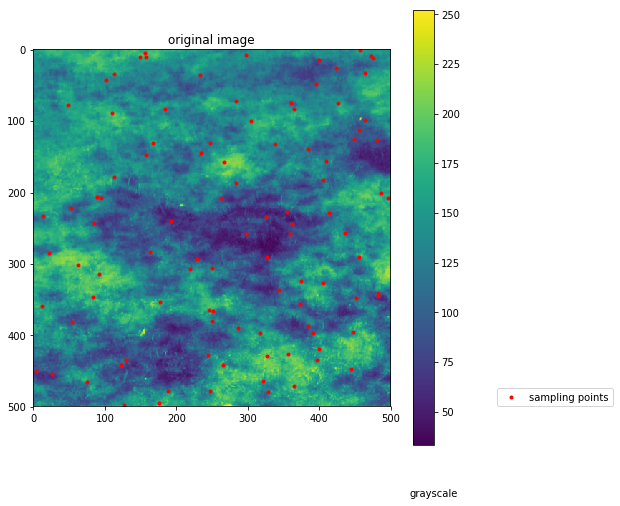

In [17]:
# Just change the 'grass.jpg' to any picture filename and perform the sequence. Results will be obtained automatically. \
# But sometimes it is essential to change some parameters such as lag_start, lag_stop, lat_step and tolerance in \
# variogram function.
# Read image
im=ndimage.imread('grass.jpg',mode='I') 
R_return=R(im,12345,100)

the Mean of the grayscale samples is 133.150000
The standard deviation of the grayscale samples is 34.712354
NormaltestResult(statistic=2.6256156035412253, pvalue=0.26906351775490533)
The two parameters: array([ 133.22020244, 1367.47683007])
Standard deviation of errors of fitting: array([ 6.43665624, 14.56073812])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


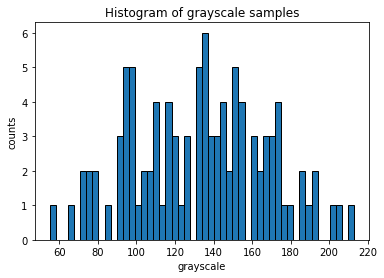

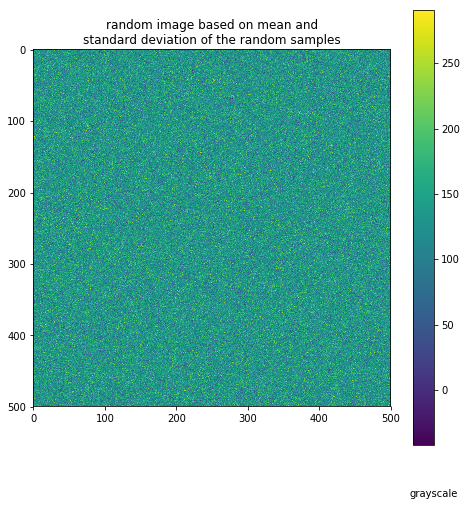

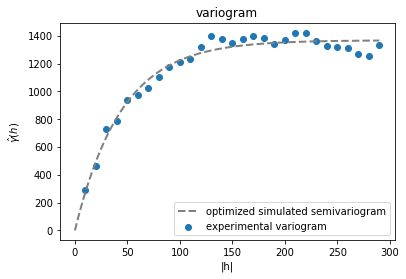

In [18]:
# SK
S(R_return,im)
variogram_return_sk=variogram(R_return,10,300,10,30)
fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,3,0.0001)
z_sk,var_sk=sk_grid(im,R_return,sk,C,100,fit_variogram_return_sk)

the Mean of the grayscale samples is 0.033244
The standard deviation of the grayscale samples is 0.982361
NormaltestResult(statistic=0.3225974667449022, pvalue=0.8510377997373713)
The two parameters: array([136.78193518,   1.10969352])
Standard deviation of errors of fitting: array([7.42409726, 0.01350152])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


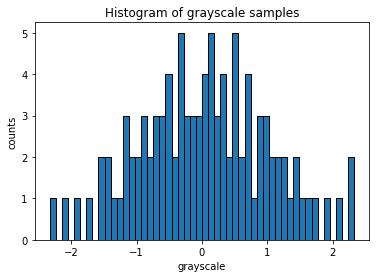

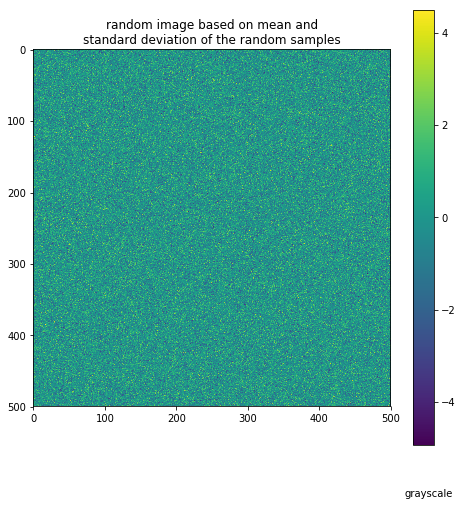

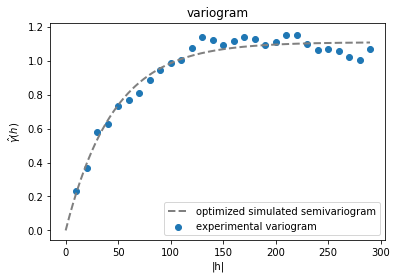

In [19]:
#SGS
R_return_sgs=np.copy(R_return)
R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])
S(R_return_sgs,im)
variogram_return_sgs=variogram(R_return_sgs,10,300,10,30)
fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,3,1)
z_sgs=sgs(im,R_return_sgs,12345,sk,C,Fz_inv,R_return,50,fit_variogram_return_sgs)

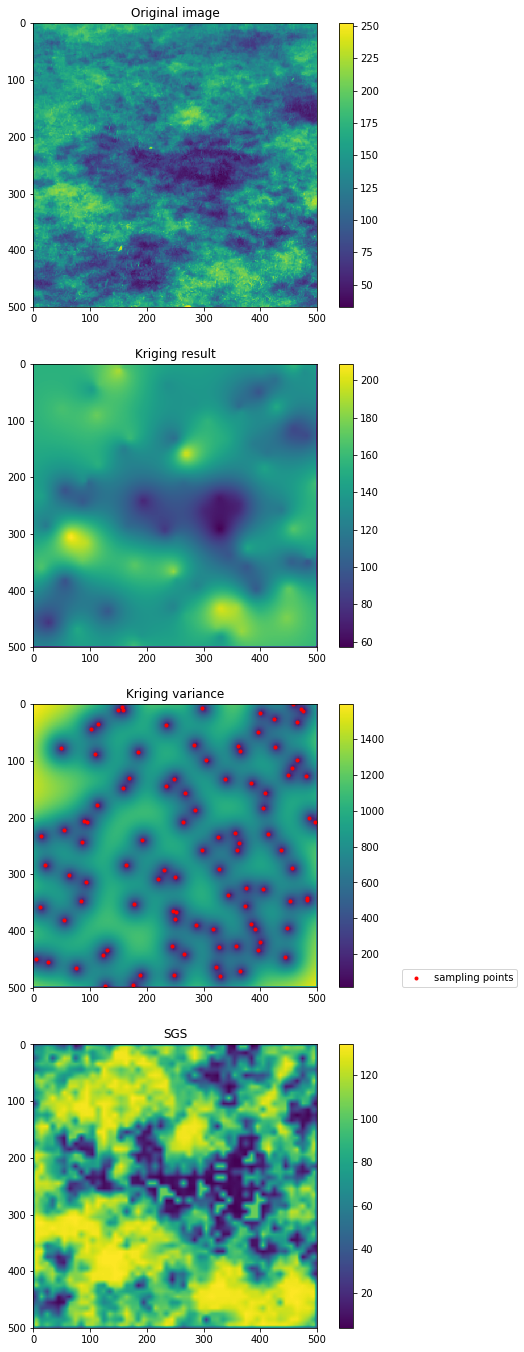

In [20]:
# Display
P_sk(im,R_return,z_sk,var_sk,z_sgs)

## Aurora

Retrived from: https://en.wikipedia.org/wiki/Aurora

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


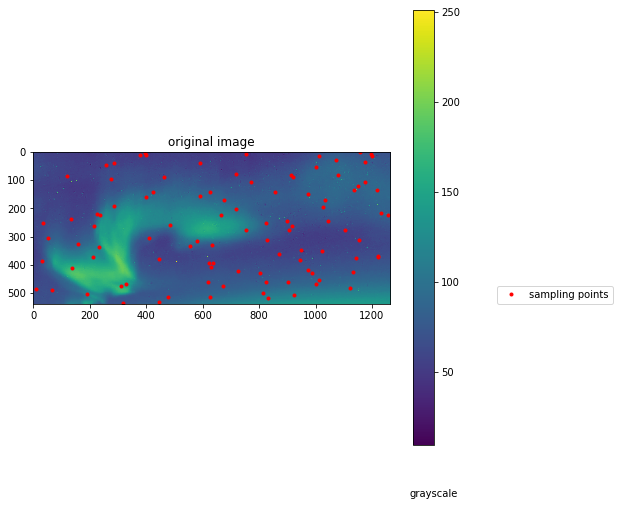

In [21]:
# Read
im=ndimage.imread('aurora.jpg',mode='I')
R_return=R(im,12345,100)

the Mean of the grayscale samples is 80.640000
The standard deviation of the grayscale samples is 21.824078
NormaltestResult(statistic=39.31751542067403, pvalue=2.899412489409094e-09)
The two parameters: array([266.14777925, 456.32123051])
Standard deviation of errors of fitting: array([24.56324454, 12.16598065])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


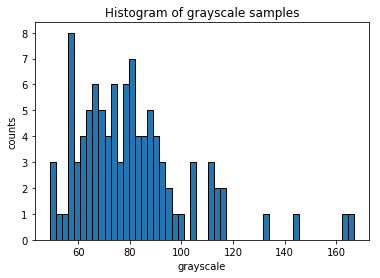

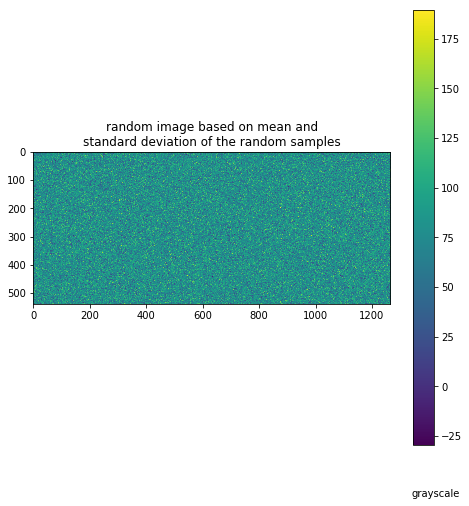

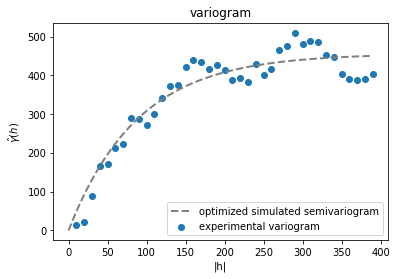

In [22]:
# SK
S(R_return,im)
variogram_return_sk=variogram(R_return,10,400,10,30)
fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,200,400)
z_sk,var_sk=sk_grid(im,R_return,sk,C,100,fit_variogram_return_sk)

the Mean of the grayscale samples is 0.050142
The standard deviation of the grayscale samples is 0.976107
NormaltestResult(statistic=0.2465266731636454, pvalue=0.8840308342479436)
The two parameters: array([312.58821955,   1.01391335])
Standard deviation of errors of fitting: array([2.20602376e+01, 1.97500666e-02])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


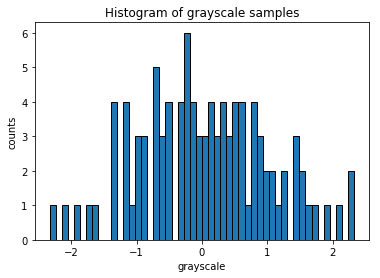

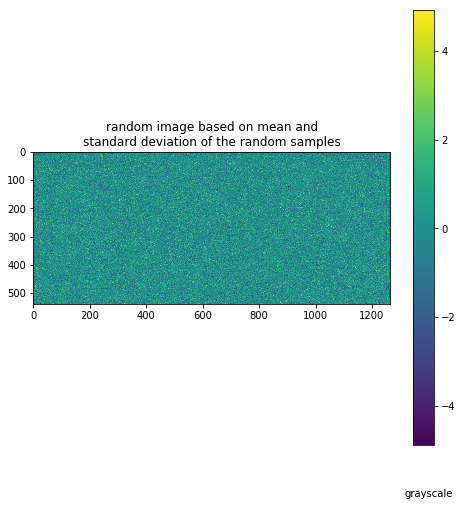

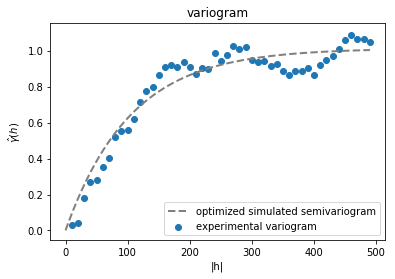

In [23]:
# SGS
R_return_sgs=np.copy(R_return)
R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])
S(R_return_sgs,im)
variogram_return_sgs=variogram(R_return_sgs,10,500,10,30)
fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,3,1)
z_sgs=sgs(im,R_return_sgs,12345,sk,C,Fz_inv,R_return,50,fit_variogram_return_sgs)

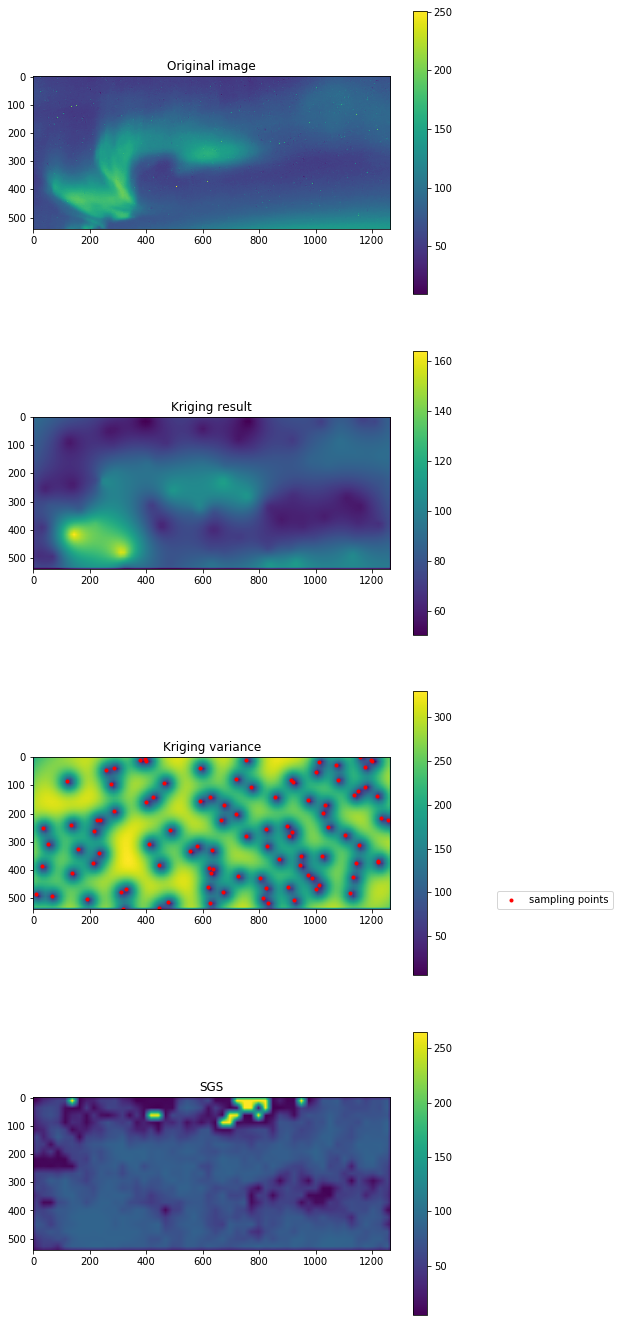

In [24]:
# Display
P_sk(im,R_return,z_sk,var_sk,z_sgs)

## Tie-dye

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


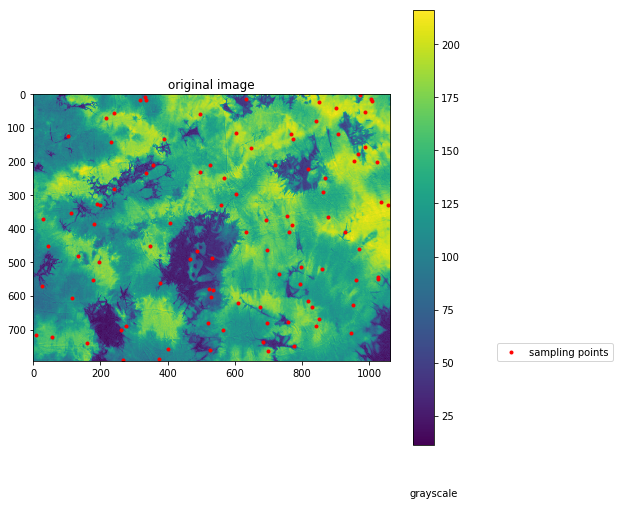

In [25]:
# Read
im=ndimage.imread('tiedye.jpg',mode='I')
R_return=R(im,12345,100)

the Mean of the grayscale samples is 134.260000
The standard deviation of the grayscale samples is 42.985491
NormaltestResult(statistic=6.232143571717597, pvalue=0.04433096837133816)
The two parameters: array([ 202.64028357, 1800.74023988])
Standard deviation of errors of fitting: array([15.38265255, 28.30695524])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


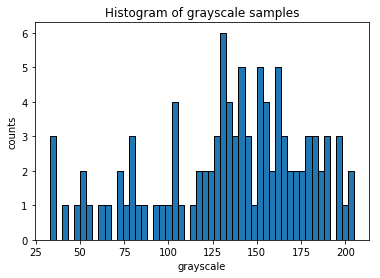

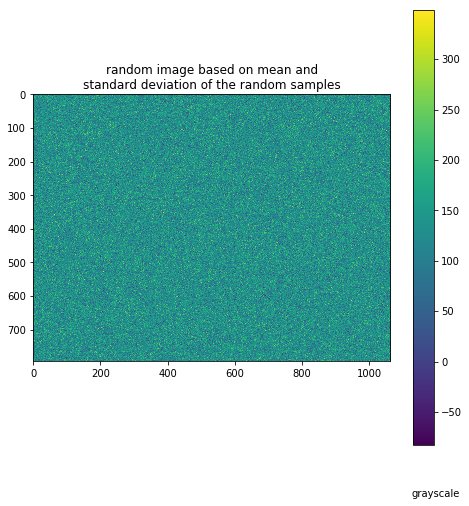

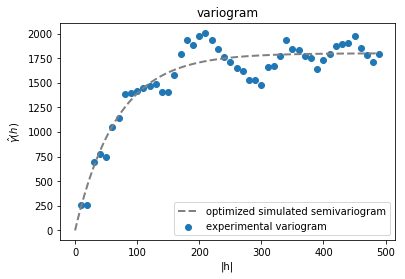

In [26]:
# SK
S(R_return,im)
variogram_return_sk=variogram(R_return,10,500,10,30)
fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,3,0.0001)
z_sk,var_sk=sk_grid(im,R_return,sk,C,100,fit_variogram_return_sk)

the Mean of the grayscale samples is 0.031884
The standard deviation of the grayscale samples is 0.982335
NormaltestResult(statistic=0.29869991882449365, pvalue=0.8612676534306141)
The two parameters: array([183.95235914,   0.87547133])
Standard deviation of errors of fitting: array([1.56528494e+01, 1.45275201e-02])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


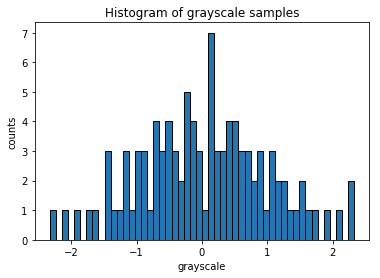

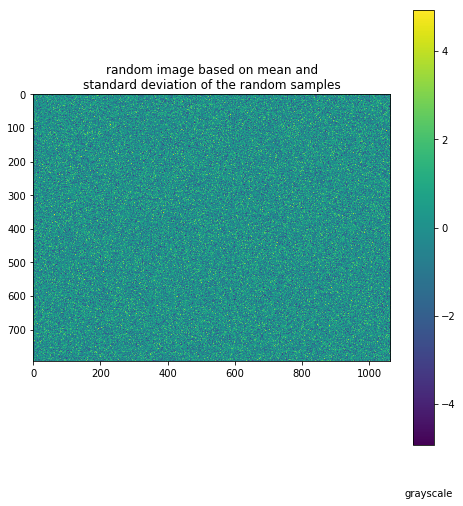

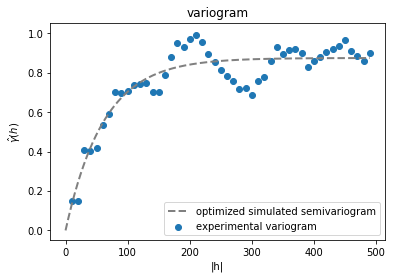

In [27]:
# SGS
R_return_sgs=np.copy(R_return)
R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])
S(R_return_sgs,im)
variogram_return_sgs=variogram(R_return_sgs,10,500,10,30)
fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,3,1)
z_sgs=sgs(im,R_return_sgs,12345,sk,C,Fz_inv,R_return,50,fit_variogram_return_sgs)

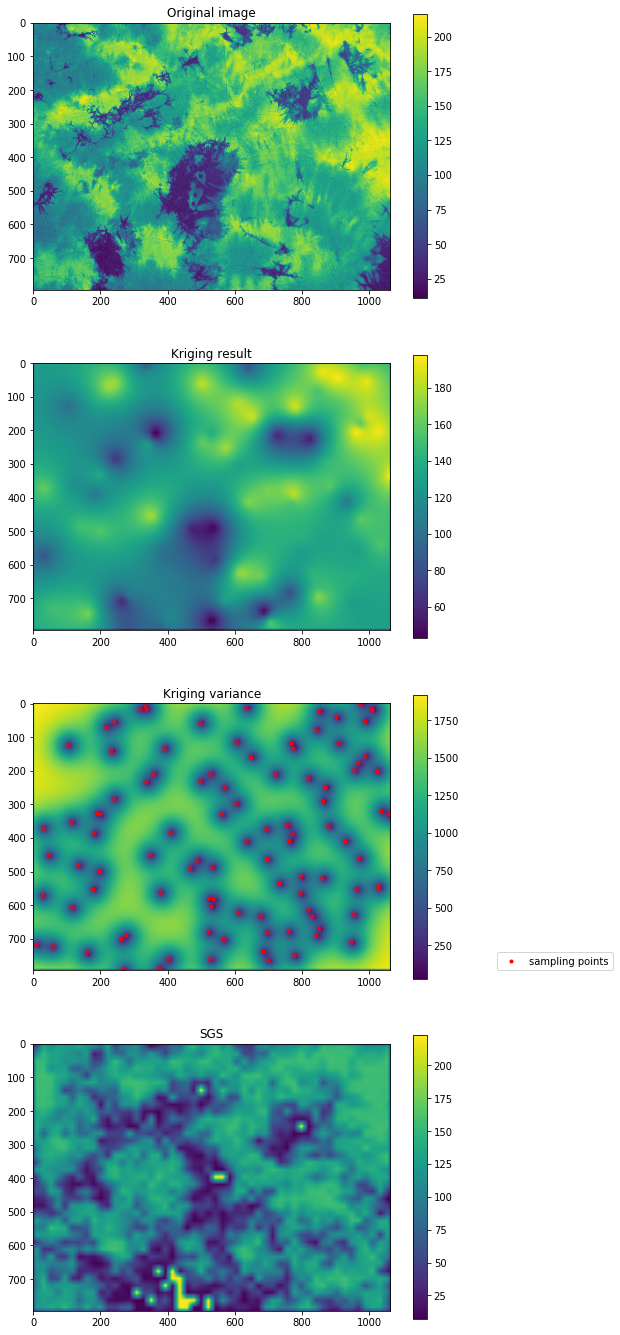

In [28]:
# Display
P_sk(im,R_return,z_sk,var_sk,z_sgs)

## Pore distribution

Distribution of pores (pores are blue in RGB image).

Ester S. B. Ferreira. (2011). Case study: Characterisation of porosity in ground layers in canvas paintings. Retrived from https://www.sik-isea.ch/de-ch/Forschung-Publikationen/Forschung/Forschungsprojekte/Synchrotron-x-ray-microtomography/Subproject-1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


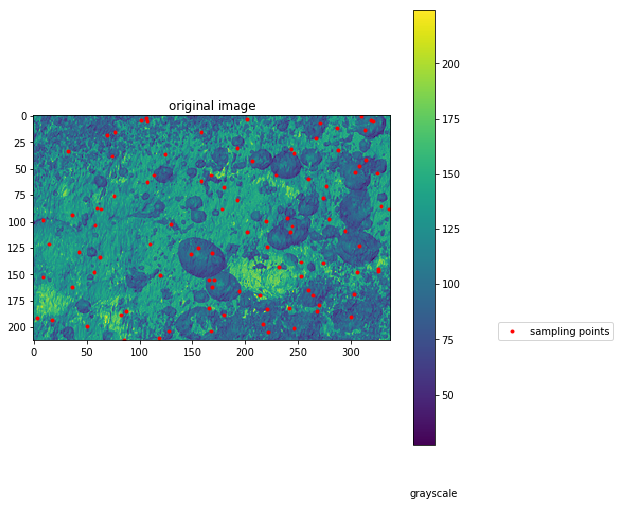

In [29]:
# Read
im=ndimage.imread('porosity.jpg',mode='I')
R_return=R(im,12345,100)

the Mean of the grayscale samples is 114.400000
The standard deviation of the grayscale samples is 27.613403
NormaltestResult(statistic=3.2087127109314757, pvalue=0.2010188979952599)
The two parameters: array([ 54.56454887, 800.23438677])
Standard deviation of errors of fitting: array([ 6.44492362, 17.63320236])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


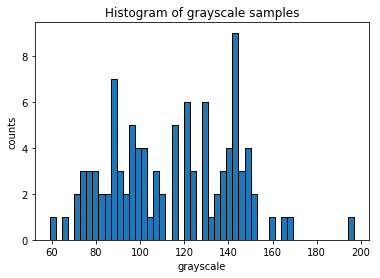

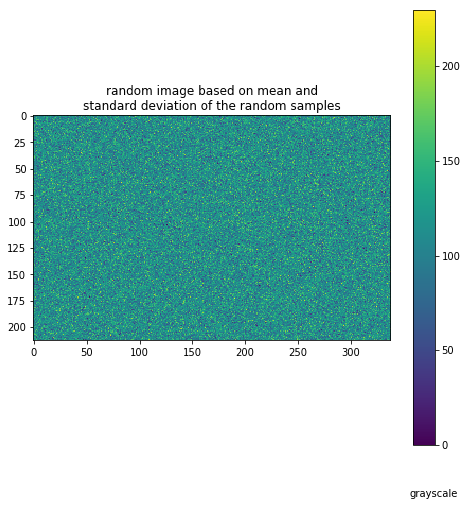

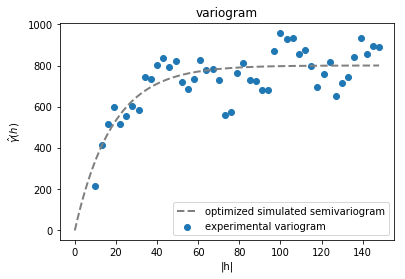

In [30]:
# SK
S(R_return,im)
variogram_return_sk=variogram(R_return,10,150,3,3)
fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,3,0.0001)
z_sk,var_sk=sk_grid(im,R_return,sk,C,100,fit_variogram_return_sk)

the Mean of the grayscale samples is 0.047221
The standard deviation of the grayscale samples is 0.982048
NormaltestResult(statistic=0.38396364522582765, pvalue=0.8253218705504445)
The two parameters: array([47.79153094,  0.99519686])
Standard deviation of errors of fitting: array([5.52458279, 0.01956157])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


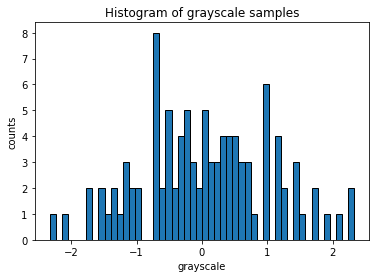

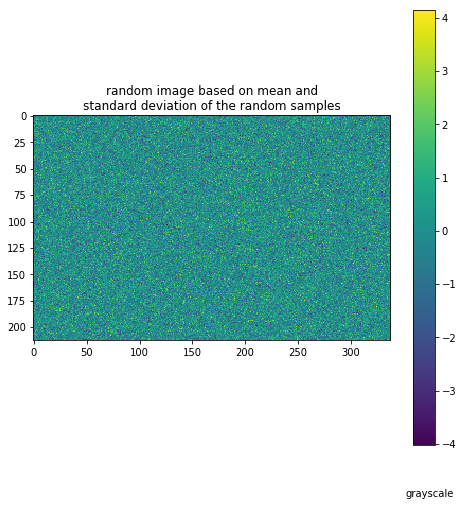

In [31]:
# SGS
R_return_sgs=np.copy(R_return)
R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])
S(R_return_sgs,im)
variogram_return_sgs=variogram(R_return_sgs,10,150,3,5)
fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,3,1)
z_sgs=sgs(im,R_return_sgs,12345,sk,C,Fz_inv,R_return,50,fit_variogram_return_sgs)

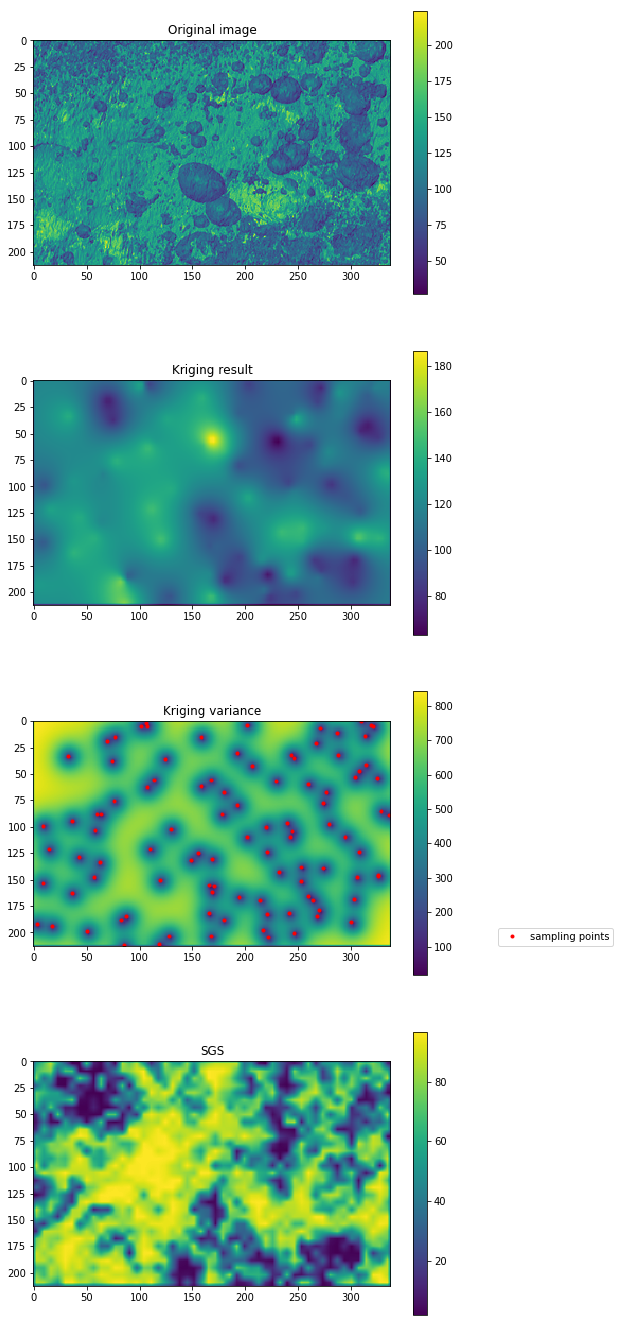

In [32]:
# Display
P_sk(im,R_return,z_sk,var_sk,z_sgs)

## Google map
Picture obtained from Google Earth:

https://earth.google.com/web/@55.54461897,61.02082411,425.91739181a,2973343.07322353d,35y,0h,0t,0r

In [33]:
# Read
im=ndimage.imread('google.jpg',mode='I')
R_return=R(im,12345,100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


the Mean of the grayscale samples is 81.310000
The standard deviation of the grayscale samples is 18.922841
NormaltestResult(statistic=6.96317036661108, pvalue=0.030758614325176206)
The two parameters: array([409.09611957, 491.11845245])
Standard deviation of errors of fitting: array([43.52668329, 20.51453289])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


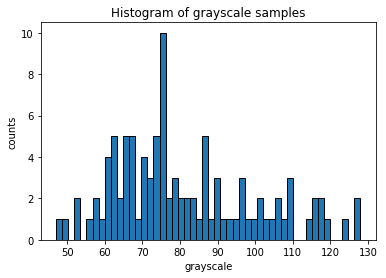

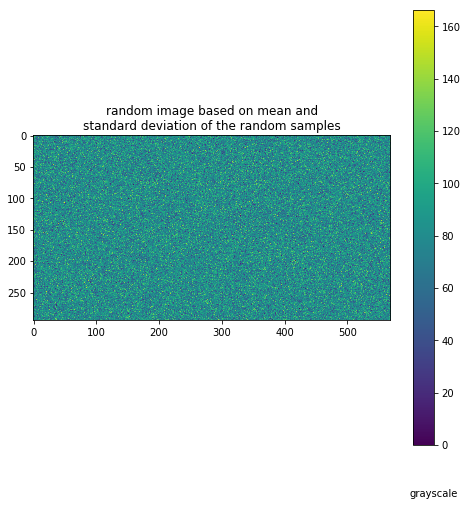

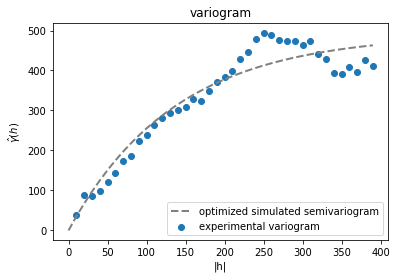

In [34]:
# SK
S(R_return,im)
variogram_return_sk=variogram(R_return,10,400,10,20)
fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,3,0.0001)
z_sk,var_sk=sk_grid(im,R_return,sk,C,100,fit_variogram_return_sk)

the Mean of the grayscale samples is 0.030085
The standard deviation of the grayscale samples is 0.983431
NormaltestResult(statistic=0.1890833583211453, pvalue=0.9097898145600288)
The two parameters: array([302.02473214,   1.17028229])
Standard deviation of errors of fitting: array([19.67162982,  0.02213271])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


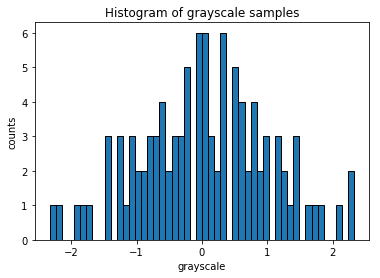

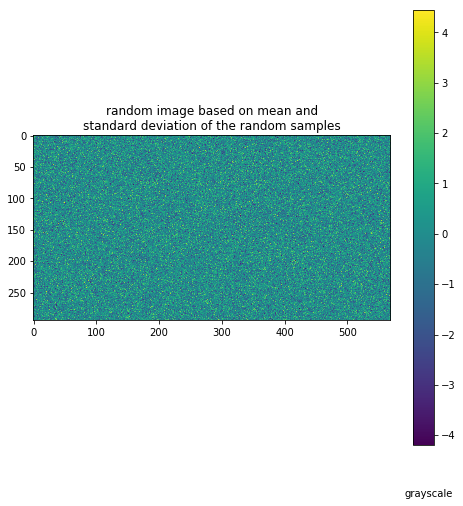

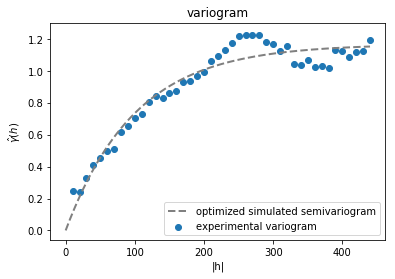

In [35]:
# SGS
R_return_sgs=np.copy(R_return)
R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])
S(R_return_sgs,im)
variogram_return_sgs=variogram(R_return_sgs,10,450,10,30)
fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,3,1)
z_sgs=sgs(im,R_return_sgs,12345,sk,C,Fz_inv,R_return,50,fit_variogram_return_sgs)

In [36]:
# Display
P_sk(im,R_return,z_sk,var_sk,z_sgs)

## Thin section

Retrived from: https://www.burivalphotography.com/tag/thin-section/

In [37]:
# Read
im=ndimage.imread('thin_section.jpg',mode='I')
R_return=R(im,12345,100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


the Mean of the grayscale samples is 120.040000
The standard deviation of the grayscale samples is 64.078845
NormaltestResult(statistic=31.477891451305204, pvalue=1.4610420665023813e-07)
The two parameters: array([ 117.44612989, 4644.7724629 ])
Standard deviation of errors of fitting: array([ 12.58203594, 101.24924318])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


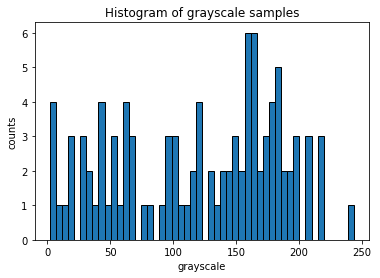

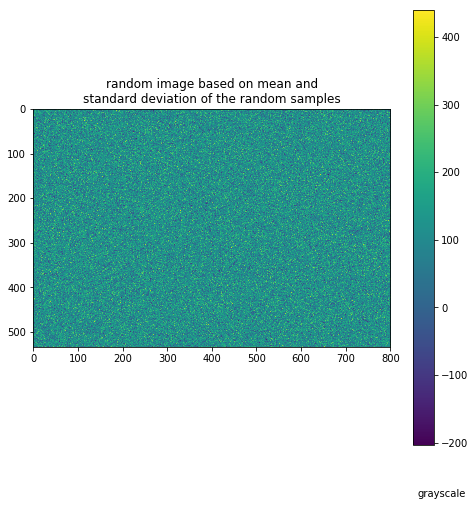

In [38]:
# SK
S(R_return,im)
variogram_return_sk=variogram(R_return,10,300,10,20)
fit_variogram_return_sk=fit_variogram(variogram_return_sk,exp_var,3,0.0001)
z_sk,var_sk=sk_grid(im,R_return,sk,C,100,fit_variogram_return_sk)

the Mean of the grayscale samples is 0.035786
The standard deviation of the grayscale samples is 0.987390
NormaltestResult(statistic=0.3510764737444454, pvalue=0.8390053156210711)
The two parameters: array([132.97151788,   1.14167826])
Standard deviation of errors of fitting: array([16.40818503,  0.03100984])


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


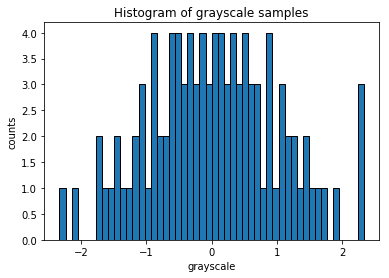

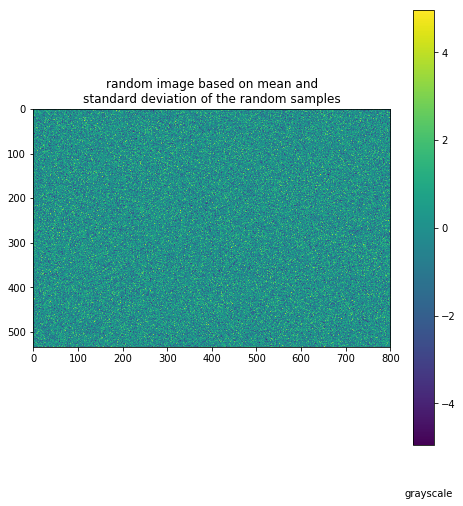

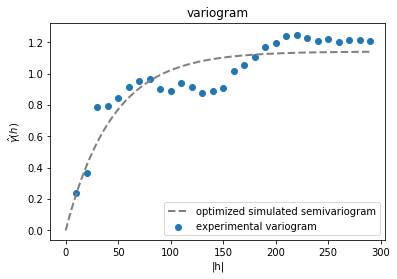

In [39]:
# SGS
R_return_sgs=np.copy(R_return)
R_return_sgs[:,2]=normalization(Fz,R_return_sgs[:,2])
S(R_return_sgs,im)
variogram_return_sgs=variogram(R_return_sgs,10,300,10,30)
fit_variogram_return_sgs=fit_variogram(variogram_return_sgs,exp_var,3,1)
z_sgs=sgs(im,R_return_sgs,12345,sk,C,Fz_inv,R_return,50,fit_variogram_return_sgs)

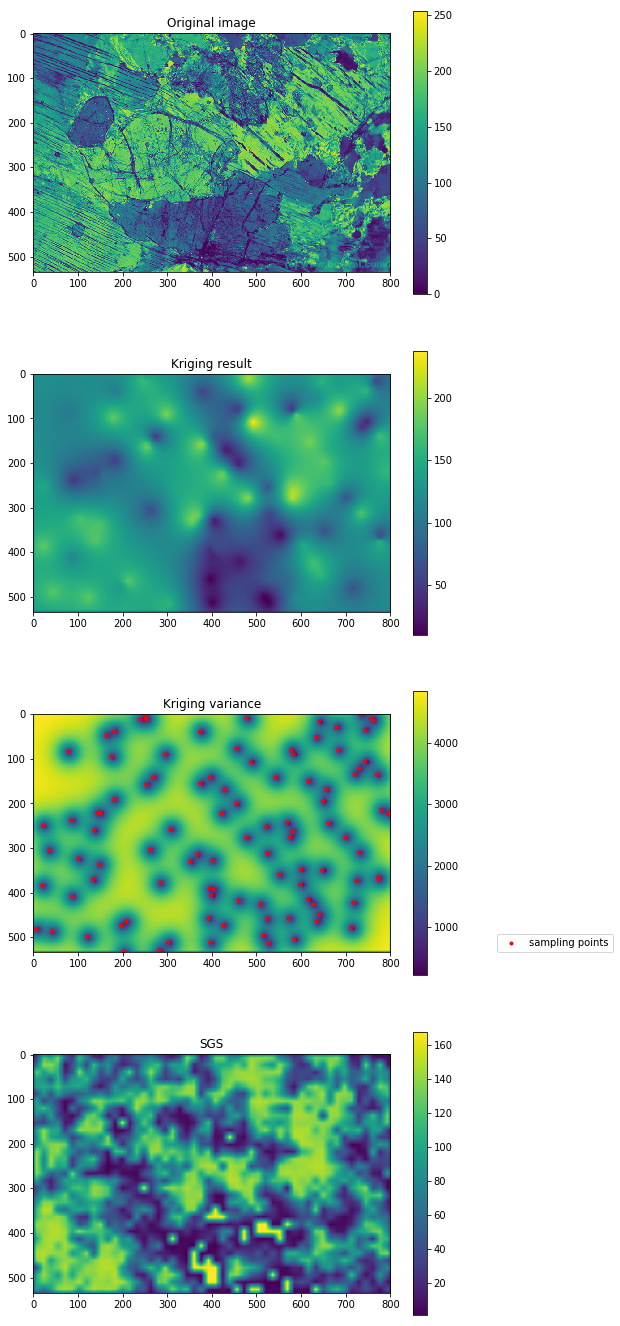

In [40]:
# Display
P_sk(im,R_return,z_sk,var_sk,z_sgs)

# Discussion

Here, 6 pictures are selected for analysis:<br>
&emsp; 2.1 Grass<br>
&emsp; 2.2 Aurora<br>
&emsp; 2.3 Tie-dye<br>
&emsp; 2.4 Pore distribution<br>
&emsp; 2.5 Google map<br>
&emsp; 2.6 Thin section<br>

## Standard statistical analysis

All the pictures are processed with function `S` for statistical analysis. According to their histogram and normal test result, it is considered only picture 2.1 and 2.4 have relatively higher possibility coming from a normal distribution. The reason is that both pvalues in normaltest are exceeding 0.05 (about 0.2-0.3). The others' pvalues are too small to be considered as a normal distribution.

pvalue for normalized data is, of course, much higher, all close to 0.9. So, the normalization is though effective.

In addition, random images are not sufficient to represent the characteristics for the original image, since random images with only mean and standard deviation do not contain the spatial information.

## Variogram

For all variogram fitting, the two parameters (sill and range) and standard deviation of errors of fitting are given in the fitting process. The standard deviation of fitting errors relative to the two parameters is reasonable for all fitting process. Also, all experimental variograms are bounded by the sill from the top. So, the variogram fitting for all experimental variograms is successful. The covariance function is ignored for plotting as it is equivalent to theoretical variogram.

## SK vs. SGS

### Different data input for SK and SGS

Again, it is essential to make it clear that SK is performed on the original data value. However, for SGS, data needs to be transformed to standard normal distribution before. Transformed data is checked with normaltest function and all of the pvalues are larger than 0.8 (close to 0.9). So, it is safe to say that transformed data is from normal distribution. After SGS, the result is transformed back from Gaussian space to real space.

### Smooth difference
Results coming from SK are much smoother compared to that of SGS. This is because that variance of estimates of SK is too small, which is:

$$ var(Y^*( \boldsymbol{u}))=C(0)-\sigma^2(\boldsymbol{u})  $$

where, <br>
&emsp; $var(Y^*( \boldsymbol{u}))$ is the kriged estimate variance;<br>
&emsp; C is the covariance function;<br>
&emsp; $\sigma^2(\boldsymbol{u})$ is the variance between estimates and dataset, which is the missing variance of $Y^*( \boldsymbol{u})$.

In SGS, this missing variance is added back through:
$$ Y_s(\boldsymbol{u})=Y^*(\boldsymbol{u})+R(\boldsymbol{u}) $$

where, <br>
&emsp; $Y_s(\boldsymbol{u})$ is the SGS estimate;<br>
&emsp; $R(\boldsymbol{u})$ is a normal distribution with mean of 0 and standard deviation of $\sigma^2(\boldsymbol{u})$.

But in my operation, $Y_s(\boldsymbol{u})$ is equivalently obtained with a normal distribution with mean of $Y^*( \boldsymbol{u})$ and standard deviation of $\sigma^2(\boldsymbol{u})$. By this step, $var(Y_s( \boldsymbol{u}))$ is ensured to be correct.

### Which is better?

For each picture analysis, it is found that SK is always locally right, which means, close to the random sample points, the estimate is more accurate. As a result, SK is better to represent pictures that is smooth, such as 2.2 Aurora and 2.5 Google map.

In contrast, SGS is more suitable to simulate pictures with extreme values, e.g., 2.3 Tie-dye and 2.6 Thin section.

For the others, the both methods have their own characteristics and it is hard to say which one is better.

# Conclusion

Standard statistical analysis is not able to analyse spatial characteristics. SK is better to be performed on smooth image. When it comes to extreme values within a picture, then SGS is a wiser choice.